In [4]:
import mido
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding, Input
import random
import matplotlib.pyplot as plt


In [33]:
files = os.listdir("parvan_proekt_music")

In [34]:
list_with_music_path = []
for file in files:
    try:
        folder = os.listdir(f"parvan_proekt_music/{file}")
        for name_of_song in folder:
            list_with_music_path.append(f"parvan_proekt_music/{file}/{name_of_song}")
    except:
        "not a folder"

In [35]:
def give_all_notes(num_of_songs=900):
    all_notes = []
    count = 0
    for i in range(num_of_songs):
        try:
            midi = mido.MidiFile(list_with_music_path[i])
            note_seq = []
            for i in range(len(midi.tracks)):
                notes = [msg.note for msg in midi.tracks[i] if msg.type=="note_on"]
                if len(notes)>0:
                    note_seq.append(notes)
            all_notes.append(note_seq)
        except:
            count+=1
            print(f"missed songs: {count}")
    
    all_notes = [seq for note in all_notes for seq in note]
    return [j for i in all_notes for j in i]
        

In [36]:
all_notes = give_all_notes()

missed songs: 1
missed songs: 2
missed songs: 3
missed songs: 4
missed songs: 5
missed songs: 6
missed songs: 7
missed songs: 8
missed songs: 9
missed songs: 10
missed songs: 11
missed songs: 12
missed songs: 13
missed songs: 14
missed songs: 15
missed songs: 16
missed songs: 17
missed songs: 18
missed songs: 19
missed songs: 20


In [38]:
len(all_notes),len(set(all_notes))

(7418315, 120)

(array([3.200000e+02, 1.139900e+04, 1.037204e+06, 1.595531e+06,
        2.197623e+06, 2.137609e+06, 3.992360e+05, 3.765000e+04,
        1.631000e+03, 1.120000e+02]),
 array([  0. ,  12.7,  25.4,  38.1,  50.8,  63.5,  76.2,  88.9, 101.6,
        114.3, 127. ]),
 <BarContainer object of 10 artists>)

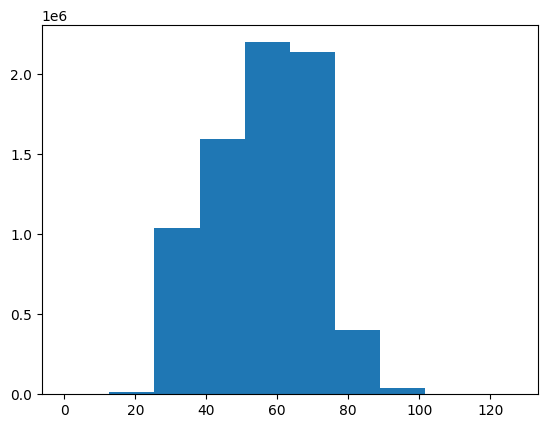

In [39]:
plt.hist(all_notes)

In [46]:
sequence_length = 25 
#step = 3

X = []
y = []

for i in range(0, len(all_notes) - sequence_length):
    input_sequence = all_notes[i:i + sequence_length]
    output_note = all_notes[i + sequence_length]
    X.append(input_sequence)
    y.append(output_note)

X = np.array(X)
y = np.array(y)


In [47]:
X = np.reshape(X, (X.shape[0], sequence_length, 1))

In [48]:
X.shape,y.shape

((7418290, 25, 1), (7418290,))

In [49]:
model = keras.Sequential()
model.add(Embedding(input_dim=max(all_notes)+1, output_dim=128, input_length=sequence_length))
model.add(LSTM(256,return_sequences=True,input_shape=(X.shape[1],X.shape[2])))
model.add(LSTM(units=512))
model.add(Dense(max(all_notes)+1, activation='softmax')) 
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

In [51]:
model.fit(X,y,batch_size=64, epochs=1)

115911/115911 [==============================] - 33927s 293ms/step - loss: 1.6966


In [92]:
start_index = random.randint(0, len(all_notes) - sequence_length - 1)
seed_sequence = all_notes[start_index:start_index + sequence_length]
generated_sequence = seed_sequence.copy()
num_notes_to_generate = 400

In [93]:
#data for plotting
a = np.zeros(max(all_notes)+1)
a = np.reshape(a,(1,max(all_notes)+1))

In [106]:
notes_that_are_used = 30 #int(num_notes_to_generate*0.03)
for _ in range(num_notes_to_generate):
    input_seq = np.reshape(generated_sequence[-sequence_length:], (1, sequence_length, 1))
    predicted_notes = model.predict(input_seq)
    a+= predicted_notes
    predicted_notes_sorted = predicted_notes.copy()[0]
    predicted_notes_sorted = sorted(predicted_notes_sorted,reverse=True)[:notes_that_are_used]  #izbirane na kolko random noti
    predicted_note_index = np.where(predicted_notes == random.choice(predicted_notes_sorted))[1][0]
    print(predicted_note_index)
    generated_sequence.append(predicted_note_index)

1/1 [==============================] - 0s 26ms/step
69
1/1 [==============================] - 0s 26ms/step
64
1/1 [==============================] - 0s 26ms/step
43
1/1 [==============================] - 0s 27ms/step
46
1/1 [==============================] - 0s 27ms/step
57
1/1 [==============================] - 0s 27ms/step
57
1/1 [==============================] - 0s 27ms/step
35
1/1 [==============================] - 0s 32ms/step
66
1/1 [==============================] - 0s 28ms/step
47
1/1 [==============================] - 0s 25ms/step
83
1/1 [==============================] - 0s 26ms/step
47
1/1 [==============================] - 0s 26ms/step
43
1/1 [==============================] - 0s 25ms/step
83
1/1 [==============================] - 0s 27ms/step
35
1/1 [==============================] - 0s 25ms/step
33
1/1 [==============================] - 0s 26ms/step
47
1/1 [==============================] - 0s 25ms/step
45
1/1 [==============================] - 0s 25ms/step
38
1/1 [=====

In [107]:
a = a/num_notes_to_generate

Text(0, 0.5, 'note')

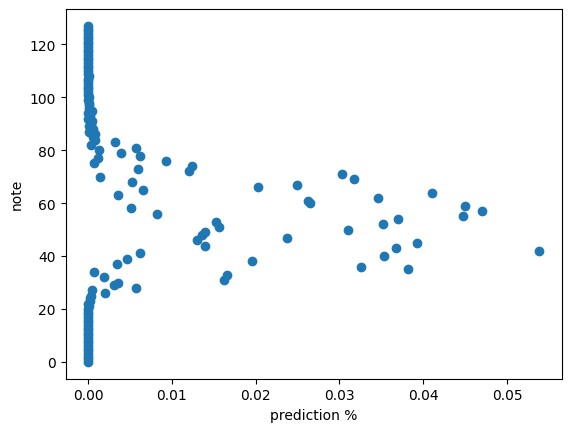

In [108]:
plt.scatter(a,[i for i in range(max(all_notes)+1)])
plt.xlabel("prediction %")
plt.ylabel("note")

In [109]:
output_midi = mido.MidiFile()
track = mido.MidiTrack()
output_midi.tracks.append(track)
program_change = mido.Message('program_change', program=0)
track.append(program_change)

In [110]:
for seq in generated_sequence[sequence_length:]:
    time = random.randint(100,130)
    track.append(mido.Message('note_on', note=seq, velocity=64, time=105))
    #track.append(mido.Message('note_off', note=seq, velocity=64, time=105))

In [111]:
output_midi.save('ai music/82.mid')


In [114]:
model.save("ai music project LSTM RNN.keras")